# BPNet Vignette

Model interpretations at selected loci for all cell states.

**Inputs**:
1. Cell type specific BPNet models

In [1]:
import keras
import pyfaidx
import math
import pandas as pd
import tqdm
import numpy as np
import pyBigWig
import scipy
from modisco.visualization import viz_sequence
import keras.backend as K
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from collections import defaultdict
import logomaker

Using TensorFlow backend.
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/s

In [10]:
import os
os.environ["HDF5_USE_FILE_LOCKING"]="FALSE"

In [320]:
from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/chrombpnet-lite/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from metrics import softmax 

In [3]:
import shap
from utils.shap_utils import *

## Load Input Data

In [4]:
# "old" cluster IDs
CELL_STATES = [1,11,14,4,5,6,8]

In [5]:
MODEL_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/"

In [6]:
# BIGWIG_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx{}.bw"
# PRED_BIGWIG_BASE = MODEL_BASE + "/cluster_idx{}/predict/cluster_idx{}_w_bias.bw"
# IMP_BIGWIG_BASE = MODEL_BASE + "/cluster_idx{}/interpret/bigwig/counts.importance.bw"

In [7]:
# bigwigs = dict()
# pred_bigwigs = dict()
# imp_bigwigs = dict()

# for x in CELL_STATES:
#     bigwigs[x] = pyBigWig.open(BIGWIG_BASE.format(x))
#     pred_bigwigs[x] = pyBigWig.open(PRED_BIGWIG_BASE.format(x, x))
#     imp_bigwigs[x] = pyBigWig.open(IMP_BIGWIG_BASE.format(x, x))

In [11]:
# load models
bias_models = dict()
models = dict()
with CustomObjectScope({'multinomial_nll': multinomial_nll}):
    for x in CELL_STATES:
        model_paths = list(Path(MODEL_BASE).glob("cluster_idx{}/*.h5".format(x)))
        assert(len(model_paths)==2)
        
        bias_model_path = str([x for x in model_paths if "adjusted" in str(x)][0])
        model_path = str([x for x in model_paths if "adjusted" not in str(x)][0])
        print(bias_model_path)
        print(model_path)
        models[x] = keras.models.load_model(model_path)
        bias_models[x] = keras.models.load_model(bias_model_path)

/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/IkhV3.adjusted_bias_model.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/IkhV3.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/VVoE9.adjusted_bias_model.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/VVoE9.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx14/I55cu.adjusted_bias_model.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx14/I55cu.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx4/2nVk5.adjusted_bias_model.h5
/oak/s

In [12]:
model_count_explainers = dict()

# explainers
for x in CELL_STATES:
    model_count_explainers[x] = shap.explainers.deep.TFDeepExplainer(
            ([models[x].input[0], models[x].input[2]],
             tf.reduce_sum(models[x].outputs[1], axis=-1)),
            shuffle_several_times,
            combine_mult_and_diffref=combine_mult_and_diffref)

In [45]:
model_profile_explainers = dict()

# explainers
for x in CELL_STATES:
    weightedsum_meannormed_logits = get_weightedsum_meannormed_logits(models[x])
    model_profile_explainers[x] = shap.explainers.deep.TFDeepExplainer(
            ([models[x].input[0], models[x].input[1]],
             weightedsum_meannormed_logits),
            shuffle_several_times,
            combine_mult_and_diffref=combine_mult_and_diffref)

In [13]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [14]:
MODEL_INP_LEN = models[CELL_STATES[0]].input_shape[0][1]
MODEL_OUT_LEN = models[CELL_STATES[0]].output_shape[0][1]
print(MODEL_INP_LEN)
print(MODEL_OUT_LEN)

2000
2000


In [15]:
def softmax(x):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(norm_x)/np.sum(np.exp(norm_x), axis=1, keepdims=True)

In [78]:
# use this if quantile required is present 

counts_explain_upper_lims = dict()
counts_explain_lower_lims = dict()
    
for i in CELL_STATES:
    with open(MODEL_BASE + "cluster_idx{}/interpret/bigwig/counts.importance.stats.txt".format(i)) as f:
        d = [x.strip() for x in f]

        upper = [x for x in d if x.startswith("99.95%")]
        assert(len(upper)==1)
        upper = float(upper[0].split('\t')[1])
        
        lower = [x for x in d if ".1%" in x]
        assert(len(lower)==1)
        lower = float(lower[0].split('\t')[1])

        counts_explain_upper_lims[i] = upper
        counts_explain_lower_lims[i] = lower
        
profile_explain_upper_lims = dict()
profile_explain_lower_lims = dict()
    
for i in CELL_STATES:
    with open(MODEL_BASE + "cluster_idx{}/interpret/bigwig/profile.importance.stats.txt".format(i)) as f:
        d = [x.strip() for x in f]

        upper = [x for x in d if x.startswith("99.95%")]
        assert(len(upper)==1)
        upper = float(upper[0].split('\t')[1])
        
        lower = [x for x in d if ".1%" in x]
        assert(len(lower)==1)
        lower = float(lower[0].split('\t')[1])

        profile_explain_upper_lims[i] = upper
        profile_explain_lower_lims[i] = lower

In [53]:
counts_explain_lower_lims, profile_explain_lower_lims

({1: -0.033098,
  11: -0.028583,
  14: -0.027,
  4: -0.026186,
  5: -0.020624,
  6: -0.02483,
  8: -0.02697},
 {1: -0.006169,
  11: -0.006126,
  14: -0.005274,
  4: -0.005042,
  5: -0.004155,
  6: -0.004341,
  8: -0.005052})

In [54]:
counts_explain_upper_lims

{1: 0.213128,
 11: 0.127204,
 14: 0.171949,
 4: 0.180839,
 5: 0.124889,
 6: 0.146848,
 8: 0.175611}

In [55]:
profile_explain_upper_lims

{1: 0.053066,
 11: 0.032478,
 14: 0.040337,
 4: 0.046032,
 5: 0.039642,
 6: 0.041151,
 8: 0.051197}

## Rough Plot (Proper plotting in R)

In [32]:
LOCS = [("chr13", 47816983, "early_ZIC"), ("chr12", 44034800, "transient_AP1"), ("chr18", 770650, "transient_TFAP2")]

In [99]:
# LOC_CHR="chr1"
# LOC_CENTER = 225899430
# NAME = "LEFTY1_enh" 

# LIN28A prom chr1:26410794
# CDH1 prom chr16:68737277

In [104]:
LOC_CHR, LOC_CENTER, NAME = LOCS[1]

In [136]:
# model preds
seq = hg38[LOC_CHR][LOC_CENTER-(MODEL_INP_LEN)//2:LOC_CENTER+(MODEL_INP_LEN)//2]
seq = one_hot.dna_to_one_hot([str(seq)])

## Explanations

Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1


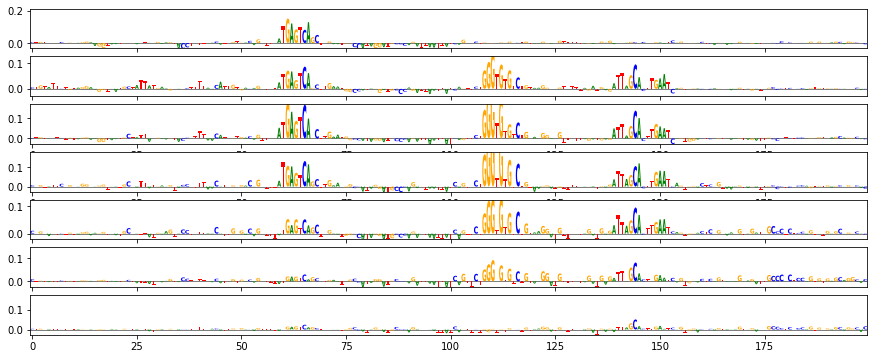

In [125]:
SLICE_START=900
SLICE_END=1100

fig, ax = plt.subplots(len(CELL_STATES), figsize=(15,6))

for i,x in enumerate(CELL_STATES):
    shap_scores = model_count_explainers[x].shap_values(
            [seq, np.zeros((seq.shape[0], 1))], progress_message=100)

#     shap_scores = model_profile_explainers[x].shap_values(
#             [seq, np.zeros((seq.shape[0], 2000))], progress_message=100)

    
    projected_shap_scores = np.multiply(seq, shap_scores[0])
    
    logomaker.Logo(pd.DataFrame(projected_shap_scores[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
              ax=ax[i])
#     plt.plot(projected_shap_scores[0])

    ax[i].set_ylim(counts_explain_lower_lims[x], counts_explain_upper_lims[x])
#     ax[i].set_ylim((profile_explain_lower_lims[x], profile_explain_upper_lims[x]))


plt.show()

In [65]:
projected_shap_scores[projected_shap_scores!=0].shape

(1997,)

In [96]:
for l_chr, l_mid, l_name in LOCS:
    f = open("./py_vignette_intermediate/{}.{}.{}.counts.explain.tsv".format(l_name, l_chr, l_mid), "w")

    f.write("\t".join(["cluster_idx", "lower_lim", "upper_lim"] + [str(x) for x in list(range(1,MODEL_OUT_LEN+1))]) + "\n")
    
    seq = hg38[l_chr][l_mid-(MODEL_INP_LEN)//2:l_mid+(MODEL_INP_LEN)//2]
    seq = one_hot.dna_to_one_hot([str(seq)])

    for x in CELL_STATES:
        shap_scores = model_count_explainers[x].shap_values(
            [seq, np.zeros((seq.shape[0], 1))], progress_message=100)

        projected_shap_scores = np.multiply(seq, shap_scores[0])
        projected_shap_scores = np.squeeze(projected_shap_scores).sum(-1) # remove last axis

        # slice to keep only out-len length
        mid = len(projected_shap_scores)//2
        projected_shap_scores = projected_shap_scores[mid-(MODEL_OUT_LEN//2):mid+(MODEL_OUT_LEN//2)]

        f.write('\t'.join([str(x), 
                           str(counts_explain_lower_lims[x]),
                           str(counts_explain_upper_lims[x])] + [str(y) for y in projected_shap_scores]) + '\n')

    f.close()

Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1


In [98]:
for l_chr, l_mid, l_name in LOCS:
    f = open("./py_vignette_intermediate/{}.{}.{}.profile.explain.tsv".format(l_name, l_chr, l_mid), "w")

    f.write("\t".join(["cluster_idx", "lower_lim", "upper_lim"] + [str(x) for x in list(range(1,MODEL_OUT_LEN+1))]) + "\n")
    
    seq = hg38[l_chr][l_mid-(MODEL_INP_LEN)//2:l_mid+(MODEL_INP_LEN)//2]
    seq = one_hot.dna_to_one_hot([str(seq)])

    for x in CELL_STATES:
        shap_scores = model_profile_explainers[x].shap_values(
            [seq, np.zeros((seq.shape[0], 2000))], progress_message=100)

        projected_shap_scores = np.multiply(seq, shap_scores[0])
        projected_shap_scores = np.squeeze(projected_shap_scores).sum(-1) # remove last axis

        # slice to keep only out-len length
        mid = len(projected_shap_scores)//2
        projected_shap_scores = projected_shap_scores[mid-(MODEL_OUT_LEN//2):mid+(MODEL_OUT_LEN//2)]

        f.write('\t'.join([str(x), 
                           str(profile_explain_lower_lims[x]),
                           str(profile_explain_upper_lims[x])] + [str(y) for y in projected_shap_scores]) + '\n')

    f.close()

Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1
Done 0 examples of 1


## Compare peak vs non peak

In [146]:
f = pyBigWig.open("/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx1.bw")

In [210]:
NONPEAK = ("chr12", 44034800)
PEAK = ("chr3", 55327064+250)

In [211]:
seqs = one_hot.dna_to_one_hot([str(hg38[NONPEAK[0]][NONPEAK[1]-1000:NONPEAK[1]+1000]),
                               str(hg38[PEAK[0]][PEAK[1]-1000:PEAK[1]+1000])])

In [281]:
nonpeak_dns_cts = []
peak_dns_cts = []

for i in range(10):
    dns = np.expand_dims(dinuc_shuffle(seqs[0]), 0)
    nonpeak_dns_cts.append(models[1].predict([dns, np.zeros((1,2000)), np.zeros((1,1))])[1][0][0])
    
    dns = np.expand_dims(dinuc_shuffle(seqs[1]), 0)
    peak_dns_cts.append(models[1].predict([dns, np.zeros((1,2000)), np.zeros((1,1))])[1][0][0])

In [282]:
np.mean(nonpeak_dns_cts), np.mean(peak_dns_cts)

(2.1761804, 2.4299812)

In [212]:
xx, xxx = bias_models[1].predict(seqs)

In [256]:
xxx

array([[3.9405227],
       [4.0758247]], dtype=float32)

In [257]:
models[1].predict([seqs, xx, xxx])[1]

array([[3.9579434],
       [7.9940925]], dtype=float32)

In [267]:
models[1].predict([seqs, np.zeros((2,2000)), np.zeros((2,1))])[1]

array([[0.6439943],
       [7.974361 ]], dtype=float32)

In [214]:
np.log(np.sum(np.nan_to_num(f.values(NONPEAK[0], NONPEAK[1]- 1000, NONPEAK[1]+1000)))+1)

4.060443010546419

In [215]:
np.log(np.sum(np.nan_to_num(f.values(PEAK[0], PEAK[1]-1000, PEAK[1]+1000)))+1)

7.842278779117352

In [216]:
projected_shap_scores.shape

(2, 2000, 4)

In [264]:
projected_shap_scores.sum(-1).sum(-1)

array([-1.39306358,  4.87890961])

In [265]:
shap_scores[0].sum(-1).sum(-1)

array([3.97320554, 8.36786582])

In [319]:
# all_shaps = []
# for i in tqdm.tqdm(range(100)):
#     shap_scores = model_count_explainers[1].shap_values(
#         [seqs, np.zeros((seqs.shape[0], 1))], progress_message=100)

# #     shap_scores = model_profile_explainers[x].shap_values(
# #             [seq, np.zeros((seq.shape[0], 2000))], progress_message=100)


#     projected_shap_scores = np.multiply(seqs, shap_scores[0])
    
#     all_shaps.append(projected_shap_scores)

In [304]:
np.mean(np.vstack([x[0].sum(-1) for x in all_shaps])[:,965])

0.12631071501432595

In [308]:
np.std(np.vstack([x[0].sum(-1) for x in all_shaps])[:,965])

0.02425807242081908

In [316]:
print(np.mean(np.vstack([x[0].sum(-1) for x in all_shaps])[:,965]), 
np.min(np.vstack([x[0].sum(-1) for x in all_shaps])[:,965]),
np.max(np.vstack([x[0].sum(-1) for x in all_shaps])[:,965]))

0.12631071501432595 0.06407282239815686 0.18026597847929224


In [318]:
print(np.mean(np.vstack([x[1].sum(-1) for x in all_shaps])[:,989]), 
      np.min(np.vstack([x[1].sum(-1) for x in all_shaps])[:,989]),
    np.max(np.vstack([x[1].sum(-1) for x in all_shaps])[:,989]))

0.14569958082395895 0.09101214059628546 0.19681111574172974


In [311]:
np.std(np.vstack([x[1].sum(-1) for x in all_shaps])[:,989])

0.024120644447554507

In [299]:
np.argmax(np.vstack([x[1].sum(-1) for x in all_shaps]).sum(0))

989

In [370]:
def single_ism(seq):
    # seq -> 1 x 2000 x 4
    preds = []
    for x in np.eye(4):
        cur_seq = np.tile(seq, reps=(seq.shape[1],1,1))
        cur_seq[np.arange(seq.shape[1]), np.arange(seq.shape[1])] = x
        preds.append(models[1].predict([cur_seq, np.zeros((cur_seq.shape[0], 2000)), np.zeros((cur_seq.shape[0], 1))], 
                                       batch_size=256)[1])
    
    ref = models[1].predict([seq, np.zeros((1,2000)), np.zeros((1,1))])[1][0][0]
    return np.sqrt(((ref-np.hstack(preds))**2).sum(1)/3)

In [401]:
def single_ism_zero(seq):
    # seq -> 1 x 2000 x 4
    
    cur_seq = np.tile(seq, reps=(seq.shape[1],1,1))
    cur_seq[np.arange(seq.shape[1]), np.arange(seq.shape[1])] = 0
    preds = models[1].predict([cur_seq, np.zeros((cur_seq.shape[0], 2000)), np.zeros((cur_seq.shape[0], 1))], 
                                   batch_size=256)[1][:,0]
    
    ref = models[1].predict([seq, np.zeros((1,2000)), np.zeros((1,1))])[1][0][0]
    return ref-preds

In [402]:
def block_ism(seq, width=5):
    # seq -> 1 x 2000 x 4
    preds = []
    
    cur_seq = np.tile(seq, reps=(seq.shape[1],1,1))
    for i in range(width):
        cur_seq[np.arange(0, seq.shape[1]-i), np.arange(i, seq.shape[1])] = 0
        
    preds = models[1].predict([cur_seq, np.zeros((cur_seq.shape[0], 2000)), np.zeros((cur_seq.shape[0], 1))], 
                                   batch_size=256)[1][:,0]
    
    ref = models[1].predict([seq, np.zeros((1,2000)), np.zeros((1,1))])[1][0][0]
    return ref-preds

In [403]:
seq1_ism = single_ism_zero(seqs[:1])
seq2_ism = single_ism_zero(seqs[1:])

In [404]:
seq1_ism_block = block_ism(seqs[:1])
seq2_ism_block = block_ism(seqs[1:])

Done 0 examples of 2
Done 0 examples of 2


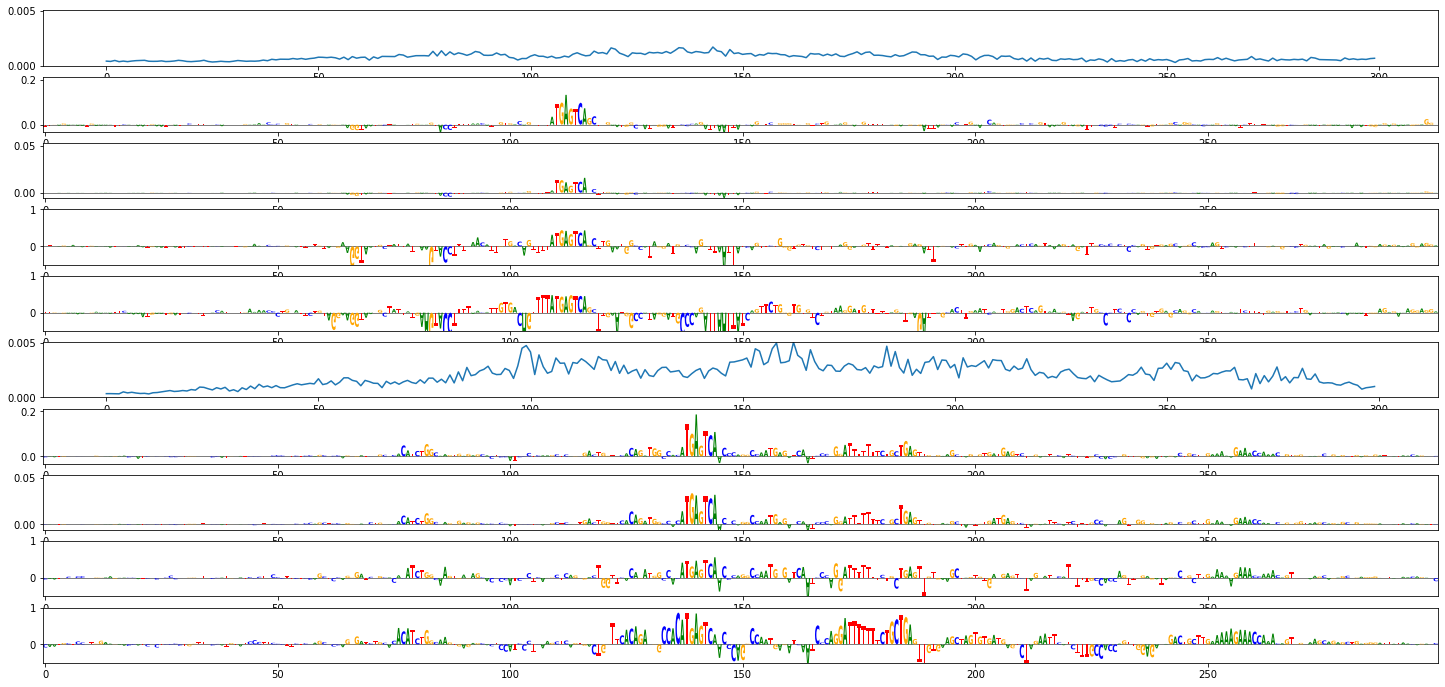

In [411]:
SLICE_START=850
SLICE_END=1150

fig, ax = plt.subplots(10, figsize=(25,12))

shap_scores = model_count_explainers[1].shap_values(
        [seqs, np.zeros((seqs.shape[0], 1))], progress_message=100)

projected_shap_scores_counts = np.multiply(seqs, shap_scores[0])

shap_scores = model_profile_explainers[1].shap_values(
        [seqs, np.zeros((seqs.shape[0], 2000))], progress_message=100)
projected_shap_scores_prof = np.multiply(seqs, shap_scores[0])


pred_prof = softmax(models[1].predict([seqs, np.zeros((2,2000)), np.zeros((2,1))])[0])

ax[0].plot(pred_prof[0][SLICE_START:SLICE_END])
ax[5].plot(pred_prof[1][SLICE_START:SLICE_END])

ax[0].set_ylim((0, np.max(pred_prof)))
ax[5].set_ylim((0, np.max(pred_prof)))
    
logomaker.Logo(pd.DataFrame(projected_shap_scores_counts[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
          ax=ax[1])
logomaker.Logo(pd.DataFrame(projected_shap_scores_prof[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
          ax=ax[2])

logomaker.Logo(pd.DataFrame((seqs[0] * np.expand_dims(seq1_ism, 1))[SLICE_START:SLICE_END], columns=['A','C','G','T']),
          ax=ax[3])
logomaker.Logo(pd.DataFrame((seqs[0] * np.expand_dims(seq1_ism_block, 1))[SLICE_START:SLICE_END], columns=['A','C','G','T']),
          ax=ax[4])


logomaker.Logo(pd.DataFrame(projected_shap_scores_counts[1][SLICE_START:SLICE_END], columns=['A','C','G','T']),
          ax=ax[6])
logomaker.Logo(pd.DataFrame(projected_shap_scores_prof[1][SLICE_START:SLICE_END], columns=['A','C','G','T']),
          ax=ax[7])
logomaker.Logo(pd.DataFrame((seqs[1] * np.expand_dims(seq2_ism, 1))[SLICE_START:SLICE_END], columns=['A','C','G','T']),
          ax=ax[8])
logomaker.Logo(pd.DataFrame((seqs[1] * np.expand_dims(seq2_ism_block, 1))[SLICE_START:SLICE_END], columns=['A','C','G','T']),
          ax=ax[9])

# ISM 
ax[3].set_ylim((-0.5, 1))
ax[8].set_ylim((-0.5, 1))

# block ISM 
ax[4].set_ylim((-0.5, 1))
ax[9].set_ylim((-0.5, 1))

# SHAP counts
ax[1].set_ylim((counts_explain_lower_lims[1], counts_explain_upper_lims[1]))
ax[6].set_ylim((counts_explain_lower_lims[1], counts_explain_upper_lims[1]))

# SHAP prof
ax[2].set_ylim((profile_explain_lower_lims[1], profile_explain_upper_lims[1]))
ax[7].set_ylim((profile_explain_lower_lims[1], profile_explain_upper_lims[1]))


plt.show()